# Milestone 3 
In this milestone our ultimate goal is to remove the disparate impact from a model. The steps are as follws:
 - Train a model with algorithmic gender bias
 - Understand the reasoning underlying the biased model
 - Measure the bias using disparate impact, thiel score, etc
 - Debias the model
 
#### Objective:

 - Build a model with algorithmic gender bias and debias it 

#### Workflow:

 - Load data
 - Train a model without unwanted gender bias
 - Demonstrate using confusion matrices that the model is not significantly biased
 - Introduce bias into the data
 - Train a biased model
 - Demonstrate using confusion matrices that the model is significantly biased
 - Use SHAP explainer to explain the model's underlying predictions
 - Load the dataset into AIF360
 - Debias the model using a pre-processing algorithm and measure the remaining bias
 - Debias the model using an in-processing algorithm and measure the remaining bias
 - Debias the model using a post-processing algorithm and measure the remaining bias
 - Choose one of the approaches, recommend it for use, and explain why

#### Importance to Project:

 - This milestone is the most challenging and important part of the project
 - After you complete this milestone you will have an understanding of how to debias models in the wild
 
#### Resources:
 - (needs updating)
 - https://christophm.github.io/interpretable-ml-book/shapley.html
 - https://christophm.github.io/interpretable-ml-book/shap.html (particularly 5.10.5, 5.10.6, 5.10.7, 5.10.8, 5.10.9 on force plots
 - https://github.com/slundberg/shap/blob/master/notebooks/tree_explainer/tree_shap_paper/Figure%204%20-%20Supervised%20Clustering%20Adult%20Census%20Data.ipynb
 - https://github.com/slundberg/shap/blob/master/notebooks/tree_explainer/Front%20page%20example%20(XGBoost).ipynb


# Import modules, register helper functions, and load data

The dataset we are using is a cardiology dataset described in the [Journal of Clinical Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6678298/). In the original dataset the 'cardio' column represented whether or not the patient has cardiovascular disease. 
    
In our scenario, we can obtain all of the measurements in the dataset but we cannot detect cardiovascular disease. Furthermore, a patient which has a prediction of cardiovascular disease will be given a medication which reduces the likelihood of a cardiac event by 50%.

So, let's set up - your tasks are as follows:
 - import the relevant modules and helper functions
 - load the data from 'cardio_train.csv',
 - drop nan values
 - sort the data by 'cardio', the target variable
 - inspect the dataframe, and familiarize yourself with the labels (see table 2 of the paper)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt    
import numpy as np
import shap
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import aif360
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.metrics import ClassificationMetric
from aif360.explainers import MetricTextExplainer

In [2]:
def generate_biased_dataset(dataset, women_yes_event_subsample_rate=0.3):
    women_no_event = dataset[(dataset['gender']==1) & (dataset['cardio']==0)]
    women_yes_event = dataset[(dataset['gender']==1) & (dataset['cardio']==1)]
    men_no_event = dataset[(dataset['gender']==2) & (dataset['cardio']==0)]
    men_yes_event = dataset[(dataset['gender']==2) & (dataset['cardio']==1)]

    biased_dataset = pd.concat([
        women_no_event,
        women_yes_event.sample(int(len(women_yes_event)*women_yes_event_subsample_rate)),
        men_no_event,
        men_yes_event
    ])
    return biased_dataset

def train_model(dataset, exclude_gender = False):
    X_cols = [c for c in dataset.columns if c!='cardio']
    X = dataset[X_cols]
    y = dataset['cardio']
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

    rf = RandomForestClassifier()
    if exclude_gender:
        X_cols.remove('gender')
    rf.fit(X_train[X_cols], y_train)
        
    return rf, X_cols, X_train, X_test, y_train, y_test

 

def plot_confusion_matrix(X,y, return_percentage=False):
    
    cm = confusion_matrix(X,y,labels=[1,0])
    
    if return_percentage:
        cm = np.round(np.asarray(cm)/(np.asarray(cm).sum()),3)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Greens',fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['positive', 'negative']); ax.yaxis.set_ticklabels(['positive', 'negative']);
    plt.show()
    
def aif360_to_pandas(dataset_aif360):
    return dataset.convert_to_dataframe()[0]
def pandas_to_aif360(dataset_pd):
    return aif360.datasets.BinaryLabelDataset(1,0,df=dataset_pd,label_names=['cardio'],protected_attribute_names=['gender'])
    

In [3]:
dataset = pd.read_csv('cardio_train.csv',delimiter=';')
dataset = dataset.dropna()

dataset.sort_values('cardio',ascending=False)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
23316,33309,19645,1,160,80.0,130,80,3,1,0,0,1,1
28870,41257,15868,1,158,83.0,160,100,1,1,0,0,1,1
55488,79158,21224,2,178,95.0,150,90,1,1,0,0,1,1
55486,79156,18111,1,164,90.0,140,1000,3,1,0,0,1,1
28862,41249,19688,1,160,63.0,110,80,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30978,44245,20991,1,164,85.0,120,80,2,1,0,0,1,0
30979,44246,16950,1,162,54.0,110,80,1,1,0,0,1,0
30980,44248,19036,1,165,89.0,130,80,1,1,0,0,1,0
30982,44250,15954,1,165,72.0,120,70,1,3,0,0,1,0


# 1. Train a model without gender bias

A model trained from this data will not be subject to significant bias. However, being able to recognize when a model isn't biased is an important part of the debiasing process. 

 - Using the helper function train_model, train a model
 - Using the helper function plot_confusion_matrix, plot a confusion matrix based on the model's predictions for the test set.
 - Split the patients in the test set by gender, and create a confusion matrix for each. 
 - Confirm that the percentage allocations of the model are equal within a couple of %. We will go into more detail about metrics later in the module, but in this case an eyeball test is all that is needed.

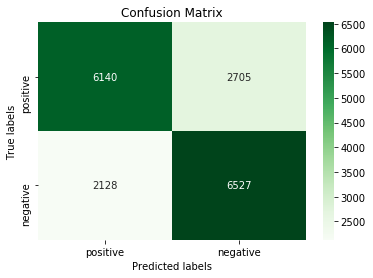

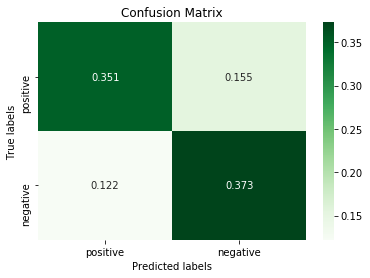

In [4]:
rf, X_cols,X_train, X_test, y_train, y_test = train_model(dataset)
plot_confusion_matrix(y_test, rf.predict(X_test[X_cols]))
plot_confusion_matrix(y_test, rf.predict(X_test[X_cols]),return_percentage=True)

confusion matrix for women in test


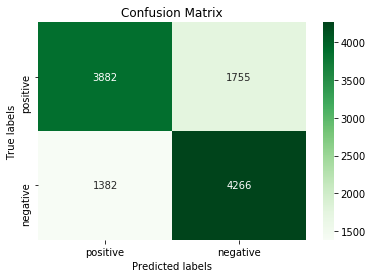

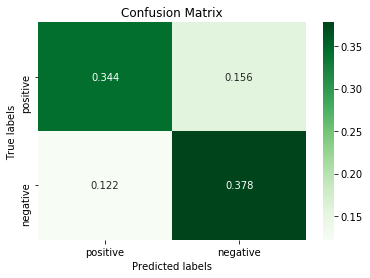

confusion matrix for men in test


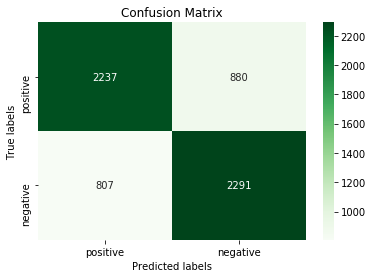

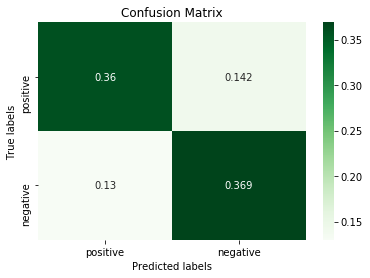

In [5]:
rf, X_cols,X_train, X_test, y_train, y_test = train_model(dataset)
women_test_idx = (X_test['gender']==1)
men_test_idx = (X_test['gender']==2)
print('confusion matrix for women in test')
plot_confusion_matrix(y_test[women_test_idx], rf.predict(X_test[X_cols][women_test_idx]))
plot_confusion_matrix(y_test[women_test_idx], rf.predict(X_test[X_cols][women_test_idx]),return_percentage=True)
print('confusion matrix for men in test')
plot_confusion_matrix(y_test[men_test_idx], rf.predict(X_test[X_cols][men_test_idx]))
plot_confusion_matrix(y_test[men_test_idx], rf.predict(X_test[X_cols][men_test_idx]),return_percentage=True)

## Introducing gender bias into data 

We can introduce gender bias into the data by manipulating the ratio of positive to negative events for either gender. In this case, we will alter the dataset by removing 80% of the occurrences where women have cardiovascular disease. In other words, on the altered data, women will have a lower likelihood of cardiovascular disease.

 - Create the biased dataset using the generate_biased_dataset helper function (we recommend a women_yes_eventsubsample_rate of 0.2)
 - Train a model based on this biased dataset using the train_model helper function
 - Plot a confusion matrix with the plot_confusion_matrix helper function
 - Create a confusion matrix for the subset of the test set where the gender is male, and a confusion matrix for the subset of the test set where gender is female. 
 - Using the confusion matrix, or other techniques, look for bias: 

    -- the statistical parity differences between men and women (compare the ratio of predicted positive instances:negative instances) should be obvious.     
    -- however, if you compare the predicted percentages of positive instances for women according to the model, with the predicted percentages of positive instances for women in the ground truth, you should see a substantial difference as well. This indicates an unwanted algorithmic bias, even accounting for the statistical parity differences we introduced

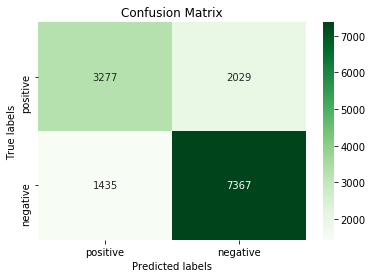

In [6]:

biased_dataset = generate_biased_dataset(dataset, women_yes_event_subsample_rate = 0.4)

rf, X_cols,X_train, X_test, y_train, y_test = train_model(biased_dataset)
plot_confusion_matrix(y_test, rf.predict(X_test[X_cols]))
#note the f1_score is roughly the same on the overall dataset

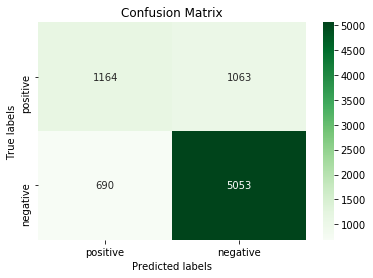

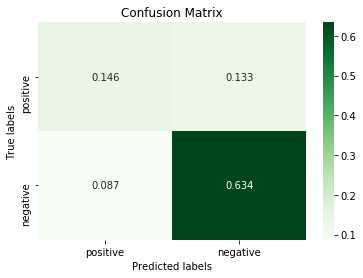

In [7]:
women_test_idx = (X_test['gender']==1)
men_test_idx = (X_test['gender']==2)

plot_confusion_matrix(
    y_test[women_test_idx], 
    rf.predict(X_test[X_cols][women_test_idx]))

plot_confusion_matrix(
    y_test[women_test_idx], 
    rf.predict(X_test[X_cols][women_test_idx]),return_percentage=True)

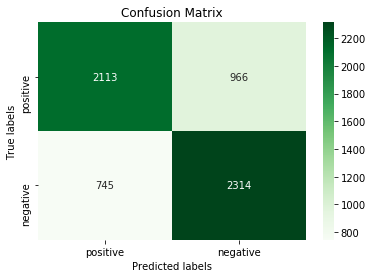

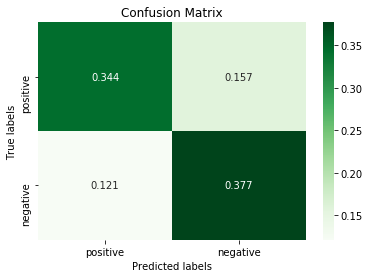

In [8]:
plot_confusion_matrix(
    y_test[men_test_idx], 
    rf.predict(X_test[X_cols][men_test_idx]),)
plot_confusion_matrix(
    y_test[men_test_idx], 
    rf.predict(X_test[X_cols][men_test_idx]),return_percentage=True)

## Diagnosing gender bias in the model using SHAP

 - It is relatively simple to show that the model is considering gender by creating a SHAP summary plot, as we learnt in milestone 1. 
 - If we were looking at this model for the first time, without prior knowledge that it had gender bias, seeing gender as a very important feature would be a red flag.
 - It is not possible to determine from the SHAP plot if the gender feature is given high importance because of genuine physiological differences, or if unwanted algorithmic bias is present.

Generate a SHAP summary plot explaining the biased model

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


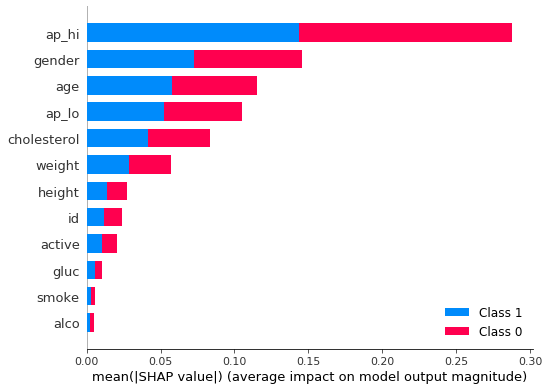

In [9]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test[:50]) #make SHAP explanation values
shap.summary_plot(shap_values, X_test[:50]) #create summary plot


## Why can't we just remove the 'gender' variable'?
An interesting question: If the SHAP value is indicating that the 'gender' variable is important, and it seems to be a source of bias, could we simply remove it rather than going through a time-consuming debiasing process? 

Unfortunately, it is usually not so simple. In this instance, like many others, the model will be able to approximate gender using other variables. Removing the variable also reduces the accuracy of the model. As an optional exercise, if you are curious, you can train a model without the 'gender' variable and confirm that removing the gender variable does not resolve all the algorithmic bias issues. You can pass in __exclude_gender=True__ to the train_model helper function.

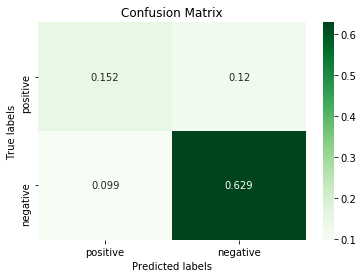

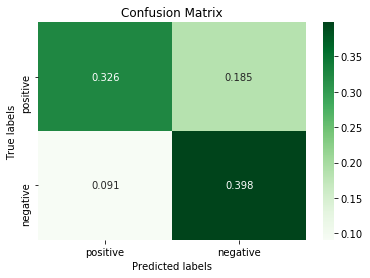

In [10]:
rf_excl_gender, no_gender_X_cols,X_train, X_test, y_train, y_test = train_model(biased_dataset, exclude_gender=True)
#note the f1_score is roughly the same on the overall dataset

women_test_idx = (X_test['gender']==1)
men_test_idx = (X_test['gender']==2)


plot_confusion_matrix(
    y_test[women_test_idx], 
    rf_excl_gender.predict(X_test[no_gender_X_cols][women_test_idx]),return_percentage=True)

plot_confusion_matrix(
    y_test[men_test_idx], 
    rf_excl_gender.predict(X_test[no_gender_X_cols][men_test_idx]),return_percentage=True)

# Introducing AIF360 - Let's debias our biased model!

At this stage, it's helpful to isolate exactly what kinds of bias we are interested in removing from our model. There are at least two obvious biases in the model we built:
 1. Due directly to our tampering with the dataset, the model predicts more positive cases for men than women.
 2. The model's errors are distributed unevenly across genders: women have a lower true positive rater than men.

The question remains which of these biases are unwanted algorithmic biases, which we should remove. 

1. In this milestone, we artifically caused (1). However, disparities between men and women can be due to general physiological differences (for example, breast cancer is [70-100 times less common in men than in women](https://www.cancer.org/cancer/breast-cancer-in-men/about/key-statistics.html). With more knowledge about the experimental setup, a subject matter expert in cardiovascular disease would be able to give a qualified answer about the source of the bias and whether or not it's unwanted. For learning purposes, we will assume that this bias is unwanted and attempt to remove it.

2. (2) is more straightforward. The model errors are unfairly distributed in such a way that borderline cases in women are more likely to be judged as negative than borderline cases in men. If we can resolve this without a substantial drop in overall accuracy, that would be preferable.

For learning purposes, we will attempt to mitigate both types of bias. 

### Steps:
 - Load entire biased dataset into AIF360
 - Using ClassificationMetric, measure key bias metrics in the biased model's predictions
 - Create debiased models using each of the following: pre-processing debiasing method (reweighing), an in-processing debiasing method (prejudice remover), and a post-processing debiasing method (calibration)
 - Decide on a preferred debiasing approach and justify your choice
 
To help you, the 

In [11]:
aif360_biased_dataset = pandas_to_aif360(biased_dataset) #this is a helper function, you could insetad use the below
# aif360_biased_dataset = aif360.datasets.BinaryLabelDataset(1,0,df=biased_dataset,label_names=['cardio'],protected_attribute_names=['gender'])
results = {}

y_val_pred = rf.predict(aif360_biased_dataset.features)
dataset_pred = aif360_biased_dataset.copy()
dataset_pred.labels = y_val_pred
dataset_pred.scores = rf.predict_proba(aif360_biased_dataset.features)[:,1]

unprivileged_groups = [{'gender':1.0}] #women
privileged_groups = [{'gender':2.0}] #men

metric = ClassificationMetric(
        aif360_biased_dataset, dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['original_dataset'] = {'accuracy':metric.accuracy(),
'statistical_parity_difference':metric.statistical_parity_difference(),
'disparate_impact':metric.disparate_impact()}

## Preprocessing the data using reweighing

In [12]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
reweigher = RW.fit(aif360_biased_dataset)

In [13]:
reweighed_dataset = reweigher.transform(aif360_biased_dataset)

y_val_pred = rf.predict(reweighed_dataset.features)
reweighed_dataset_pred = reweighed_dataset.copy()
reweighed_dataset_pred.labels = y_val_pred
dataset_pred.scores = rf.predict_proba(aif360_biased_dataset.features)[:,0]

unprivileged_groups = [{'gender':1.0}]
privileged_groups = [{'gender':2.0}]

metric = ClassificationMetric(
        reweighed_dataset, reweighed_dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['reweigher'] = {'accuracy':metric.accuracy(),
'statistical_parity_difference':metric.statistical_parity_difference(),
'disparate_impact':metric.disparate_impact()} #Bias along 3 metrics - statistical parity difference, equal opportunity difference, and disparate impact

## In-processing debiasing using Prejudice Remover

In [14]:
model = PrejudiceRemover(sensitive_attr='gender', eta=2.0) #high eta adds more penalty for bias
removed_prejudice_model = model.fit(aif360_biased_dataset)

In [15]:
y_val_pred = (model.predict(aif360_biased_dataset).labels).astype(int)
reweighed_dataset_pred = aif360_biased_dataset.copy()
reweighed_dataset_pred.labels = y_val_pred

metric = ClassificationMetric(
        aif360_biased_dataset, reweighed_dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['prejudice_remover'] = {'accuracy':metric.accuracy(),
'statistical_parity_difference':metric.statistical_parity_difference(),
'disparate_impact':metric.disparate_impact()}

## post-processing debiasing using Prejudice Remover

In [16]:
postprocessor = CalibratedEqOddsPostprocessing(unprivileged_groups, privileged_groups)
dataset_pred = aif360_biased_dataset.copy()
dataset_pred.labels = rf.predict(aif360_biased_dataset.features)
dataset_pred.scores = rf.predict_proba(aif360_biased_dataset.features)[:,1]
postprocessor.fit(aif360_biased_dataset, dataset_pred)
postprocessed = postprocessor.predict(dataset_pred)

metric = ClassificationMetric(
        aif360_biased_dataset, postprocessed,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['post-calibration'] = {'accuracy':metric.accuracy(),
'statistical_parity_difference':metric.statistical_parity_difference(),
'disparate_impact':metric.disparate_impact()}

In [19]:
pd.DataFrame(results).T 
"""reweigher has acceptable accuracy, the statistical parity difference is close to 0, and the disparate impact is close to 1. 
Since it has acceptable values for each of the criteria, and each of the others have at least one flaw, reweigher is the best.
As the reweigher is a pre-processing step, a new classifier will need to be trained with the weights supplied by reweigher.

For most sklearn classifiers, the 'fit' function will accept weights."""

,accuracy,statistical_parity_difference,disparate_impact
original_dataset,0.938579,-0.224892,0.546772
reweigher,0.934703,-0.034523,0.911009
prejudice_remover,0.724579,-0.365932,0.200503
post-calibration,0.921513,-0.262356,0.473869
